In [1]:
import numpy as np
from itertools import count
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
import csv 
from scipy.signal import butter, filtfilt
import os
import matplotlib as mpl

In [2]:
# Define the low pass filter
cutoff_freq = 0.17
sampling_freq = 4.10
def lowpass_filter(dataframe):
    b, a = butter(5, 2*cutoff_freq/sampling_freq, btype='low', analog=False)
    return filtfilt(b, a, dataframe)

### Initial code - CSV saved locally

### Initial code - MQTT sent live

In [120]:
def plot_os_csv(min,max):

    with open('/Users/thomas/Desktop/os-mqtt/os-mqtt.csv', 'r') as f:
        data = [row[0] for row in csv.reader(f)] 

    df = pd.DataFrame({'time': data, 'sensor': ['Hall' for x in data]})
    df['time'] = df['time'].apply(lambda x: int(x))

    hall_times = list(df[df.sensor=='Hall'].time)

    hall_times = hall_times[min:max]

    for i in range(len(hall_times)-1):
        frequency = 1/(hall_times[i+1]-hall_times[i])*1e9
        if i==0: 
            df.loc[df.time>=0, 'hall_freq'] = frequency/2
            df.loc[df.time>=0, 'hall_GPM'] = frequency/7.5 * 0.264172
        df.loc[df.time>=hall_times[i], 'hall_freq'] = frequency
        df.loc[df.time>=hall_times[i], 'hall_GPM'] = frequency/7.5 * 0.264172

    # Low pass filer
    df['hall_GPM_bias_filtered'] = lowpass_filter(df['hall_freq'])

    # Exponential weighted average
    alpha = 0.65
    W = [0]*len(df)
    theta = list(df.hall_freq)
    for t in range(len(df)-1):
        W[t+1] = alpha*W[t] + (1-alpha)*theta[t+1]
    df['hall_GPM_bias_expWA'] = W

    # Get rid of outliers
    upper_limit = 100
    df.loc[df['hall_freq'] > upper_limit, 'hall_freq'] = np.nan
    df.loc[df['hall_GPM'] > upper_limit, 'hall_GPM'] = np.nan
    df.loc[df['hall_GPM_bias_filtered'] > upper_limit, 'hall_GPM_bias_filtered'] = np.nan
    df.loc[df['hall_GPM_bias_expWA'] > upper_limit, 'hall_GPM_bias_expWA'] = np.nan
    df['hall_freq'] = df['hall_freq'].mask(df['hall_GPM'].isnull()).ffill()
    df['hall_GPM_bias_filtered'] = df['hall_GPM_bias_filtered'].mask(df['hall_GPM_bias_filtered'].isnull()).ffill()
    df['hall_GPM_bias_expWA'] = df['hall_GPM_bias_expWA'].mask(df['hall_GPM_bias_expWA'].isnull()).ffill()

    # Plot results
    plt.figure(figsize=(6,5))
    plt.plot(list(df.time)[min:max], list(df.hall_freq)[min:max], alpha=0.15, label=f'Hall effect', color='black')
    plt.plot(list(df.time)[min:max], list(df.hall_GPM_bias_expWA)[min:max], alpha=0.7, label=f'Hall effect, expWA', color='tab:blue')
    plt.plot(list(df.time)[min:max], list(df.hall_GPM_bias_filtered)[min:max], alpha=0.7, label=f'Hall effect, filtered', color='tab:orange')
    plt.ylabel('Frequency')
    plt.xlabel('Time')

    plt.show()

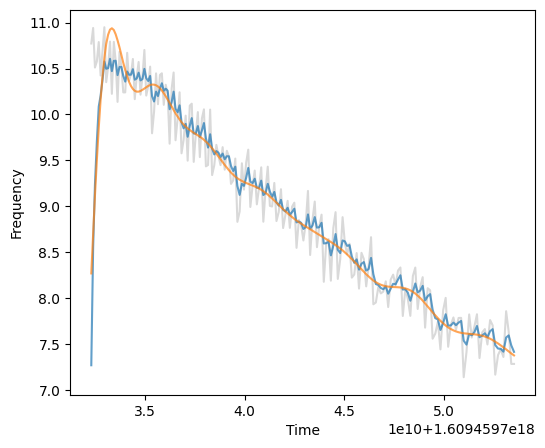

In [121]:
# 10 Hz
plot_os_csv(210,400)

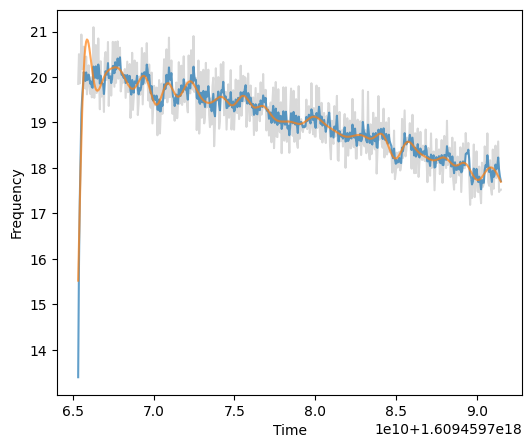

In [122]:
# 20 Hz
plot_os_csv(600,1100)

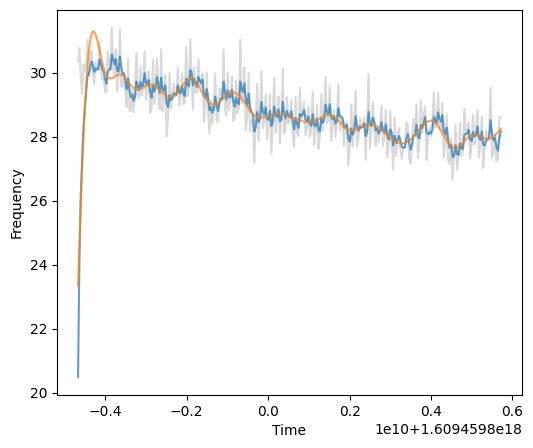

In [123]:
# 30 Hz
plot_os_csv(1200,1500)

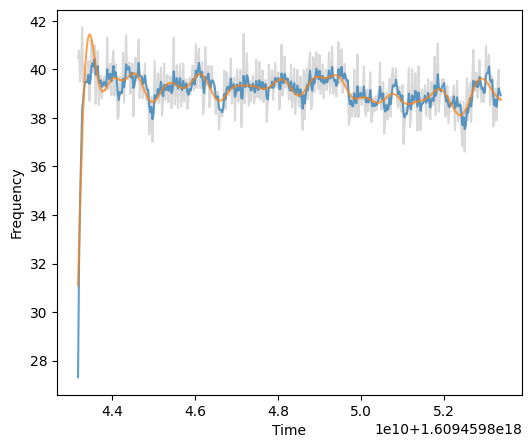

In [124]:
# 40 Hz
plot_os_csv(2700,3100)

### State machine code - MQTT sent live

In [125]:
def plot_sm_mqtt(min,max):

    with open('/Users/thomas/Desktop/os-mqtt/sm-mqtt-1.csv', 'r') as f:
        data = [row[0] for row in csv.reader(f)] 

    df = pd.DataFrame({'freq': data, 'timestamp': data, 'sensor': ['Hall' for x in data]})
    df['freq'] = df['freq'].apply(lambda x: float(x.split('-')[-1]))
    df['hall_GPM'] = df['freq'].apply(lambda x: x/7.5 * 0.264172)
    df['timestamp'] = df['timestamp'].apply(lambda x: int(x.split('-')[0]))

    # Low pass filer
    df['hall_GPM_bias_filtered'] = lowpass_filter(df['freq'])

    # Exponential weighted average
    alpha = 0.65
    W = [0]*len(df)
    theta = list(df.freq)
    for t in range(len(df)-1):
        W[t+1] = alpha*W[t] + (1-alpha)*theta[t+1]
    df['hall_GPM_bias_expWA'] = W

    # Plot results
    plt.figure(figsize=(6,5))
    plt.plot(list(df.timestamp)[min:max], list(df.freq)[min:max], alpha=0.15, label=f'Hall effect', color='black')
    plt.plot(list(df.timestamp)[min:max], list(df.hall_GPM_bias_expWA)[min:max], alpha=0.7, label=f'Hall effect, expWA', color='tab:blue')
    plt.plot(list(df.timestamp)[min:max], list(df.hall_GPM_bias_filtered)[min:max], alpha=0.7, label=f'Hall effect, filtered', color='tab:orange')
    plt.ylabel('Frequency')
    plt.xlabel('Time')

    plt.show()

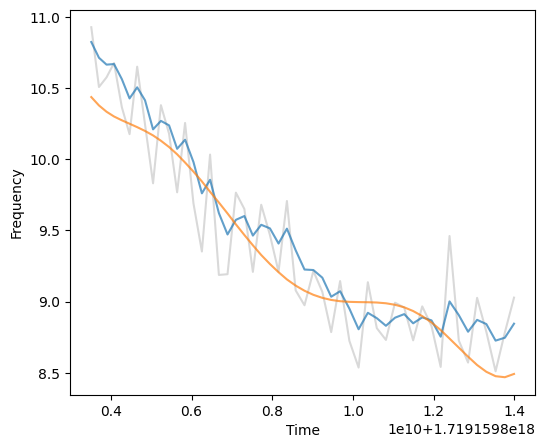

In [126]:
plot_sm_mqtt(100,150)

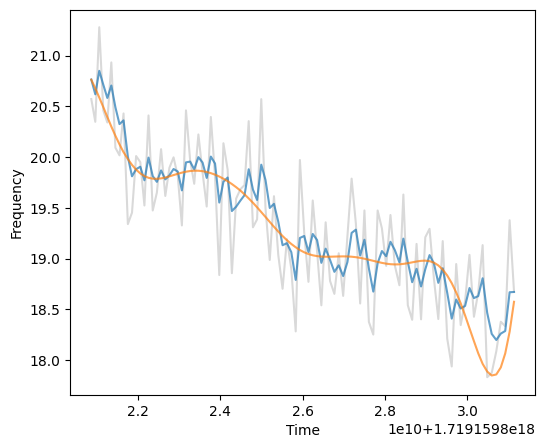

In [127]:
plot_sm_mqtt(200,300)

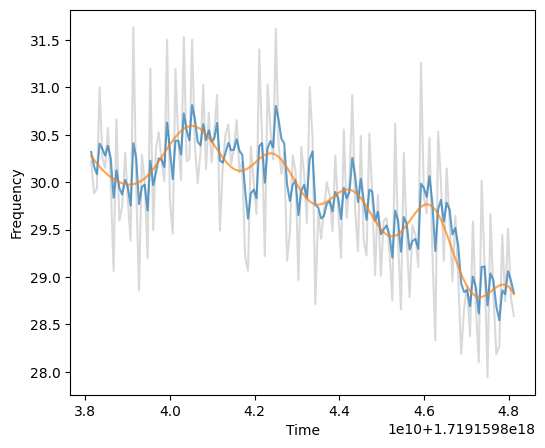

In [128]:
plot_sm_mqtt(400,550)

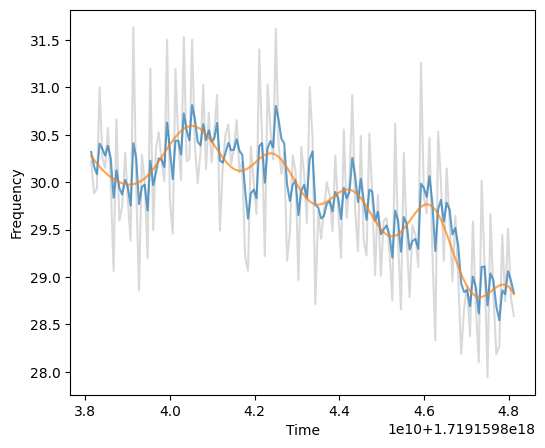

In [129]:
plot_sm_mqtt(400,550)